# Learn DNN


add conv layer
add l2 regularizer
add LSTMBlockFused
try LSTMcudnn
remove dropout to add optimized graph, add quantized graph

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import sys
sys.path.append('Codes')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from dataShaping import *
from savePerf import *
from saveTransformedGraph import optimizeGraph
import scipy.io.wavfile
import time
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import *




modelName = "DNN1"
# create directory experiment
date = time.strftime("%Y-%m-%d-%H-%M")
path = os.path.join("Experiments",date)
if not os.path.isdir(path):
    os.makedirs(path)
    #experiment/"date"/temp will contain the backuped model parameters
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
    # if you run the file two time in a minute
else :
    date = date+'(2)'
    path = os.path.join("Experiments",date)
    os.makedirs(path)
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)

# directory that will contain tensorboard information
pathLog = 'Tf_logs'
if not os.path.isdir(pathLog):
    os.makedirs(pathLog)
pathLog = "{}/run-{}/".format(pathLog,date)

version = tf.__version__
print ("version {} of tensorflow".format(version))

#############################
# Model parameters
#############################
trainTestRatio = 0.8
#if you cannot load all the data set in Ram specify wich part you want to load (0 means all the dataset)
maxSize = 0
num_step = 150                                       # time step before reduction
conv_chan = [35 , 70]                                         #number of kernel for convolution
conv_strides = 3#int(np.ceil(num_step/num_LSTM))                  #decay between two convolution
conv_size = 12                                         #filter size for the convolution
size_poll = 4
reg_scale = 0
l1l2Prop = 0.4  # 1 =>l1, 0=> l2
reg_scale_l1 = l1l2Prop*reg_scale
reg_scale_l2 = ((1-l1l2Prop)/2)*reg_scale
num_hidden = 200                                      #num of hidden units
num_class = 1                                          #size of the output
num_feature = 1                                        # size of the input
batch_size = 2500                                   # number of sequence taken before to compute the gradient
n_layer = 1                                             #num_layer

#num_hidden = num_hidden/keep_prob
num_epoch = 100000                                      # process all the datas num_epoch times
trainDuration = 60*60*10                             # or during a determined duration(second)
amplifierName = 'MesaMarkVDisto'
fileNameTrain = 'Datasets/training'+amplifierName+'.mat'             #dataset train/test path
fileNameTest = 'Datasets/test'+amplifierName+'.mat' # dataset validation path
fileNameValidation = 'Datasets/val'+amplifierName+'.mat'

#############################
# Loading data
#############################
matrix = sio.loadmat(fileNameTrain)
matrixTrain = matrix['train']
matrix = sio.loadmat(fileNameTest)
matrixTest = matrix['test']
if maxSize ==0:
    maxSize = len(matrixTrain)
    print("maxSize = {}".format(maxSize))

train_input,train_output,test_input,test_output = loadInputOutputSeq(matrixTrain,matrixTest,num_step,maxSize)

print("shape input train {}".format(np.shape(train_input)))
numTrain = len(train_output)
print ("Data loaded")
#######################
#Graph
#######################

G = tf.Graph()
with G.as_default():
    with tf.name_scope("placeHolder"):
        data = tf.placeholder(tf.float32, [None, num_step], name ="data") #Number of examples, number of input step (time step), dimension of each input
        target = tf.placeholder(tf.float32, [None, num_class],name = "target") # batchSize, nbClass
    
    with tf.variable_scope("DNNLayers"):
        FC1 = fully_connected(data,1000,activation_fn=tf.nn.relu,weights_regularizer=None,scope="FC1")
        FC2 = fully_connected(FC1,500,activation_fn=tf.nn.relu,weights_regularizer=None,scope="FC2")
        
        
    prediction = fully_connected(FC2,int(target.get_shape()[1]),activation_fn=tf.nn.tanh,weights_regularizer=None,scope="FCPred")

    #Compute the mean square error
    MSE = tf.reduce_mean(tf.square(prediction-target))
    EnergyTarget = tf.reduce_mean(tf.square(target)) 
    
    #get regularizer
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    MSEReg = tf.add_n([MSE]+reg_losses,name="MSEReg")
    # create optimizer
    optimizer = tf.train.AdamOptimizer()
    #Compute gradient and apply backpropagation
    minimize = optimizer.minimize(MSEReg)

    # Create summary view for tensorboard
    mse_summary = tf.summary.scalar('RMSE',tf.sqrt(MSE))
    #kernels = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,'ConvLayers/C1/kernel')[0]
    #kernels1 = tf.reshape(tf.slice(kernels,[0,0,0,0],[12,1,1,1]),[-1])
    #kernels2 = tf.reshape(kernels,[1,12,30,1])
    #imag_summary=tf.summary.image('kernels',kernels2,max_outputs=1)
    #histogram_summary = tf.summary.histogram('kernelC1',kernels1)
    summary_op = tf.summary.merge_all()
    
    #Create an init op to initialize variable
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver() # save variable, use saver.restore(sess,"date/tmp/my_model.ckpt") instead of sess.run(init_op)

##############################
# Execution du graphe
##############################
    
with tf.Session(graph=G) as sess:
    #restorePath = os.path.join('2017-09-11-18-07','temp','my_model.ckpt') # example for restore a previous model
    #saver.restore(sess,restorePath)
    sess.run(init_op)
    train_writer = tf.summary.FileWriter(pathLog+'train',graph =tf.get_default_graph())
    test_writer = tf.summary.FileWriter(pathLog+'test')

    no_of_batches = int(np.floor((numTrain)/batch_size)) # numtrain -numstep ?
    no_of_batchesTest = int(np.floor((len(test_input))/batch_size))
    tStart = time.clock()
    epoch =0
    bestRMSE = 1
    for epoch in range(num_epoch):
        tEpoch = time.clock()
        if (time.clock()-tStart < trainDuration):
            ptr = 0
            if epoch % 20==0 : # each ten epoch save the model
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myGraph.pb',as_text=False)
                save_path = saver.save(sess,os.path.join(pathTemp,'myModel.ckpt'))
            pMSETrain=0
            for j in range(no_of_batches):
                inp, out = train_input[ptr:ptr+batch_size],train_output[ptr:ptr+batch_size]
                ptr+=batch_size
                if j % np.floor(numTrain/len(test_input)) ==0 : # This is to have a train summary and a test summary of the same size
                    #pdataShaped = sess.run(intermediate,{data: inp, target: out})
                    #print("shape:{}".format(np.shape(pdataShaped)))
                    _,summary_str,pMSETrainTemp = sess.run([minimize,summary_op,MSE],{data: inp, target: out})
                    
                    #print("shape:{}".format(numTrain/len(test_input)))
                    #print("Kernels1:{}".format(pKernels1))
                    #print("Kernels2:{}".format(pKernels2))
                    pMSETrain += pMSETrainTemp
                    step = epoch*no_of_batches+j
                    train_writer.add_summary(summary_str,step)
                else :
                    sess.run([minimize],{data: inp, target: out})
                    #[print(n.name) for n in tf.get_default_graph().as_graph_def().node]
                   
            RMSETrain = np.sqrt(pMSETrain/no_of_batchesTest)
            print ("Epoch -{} calculated in {:5.2f} s ".format(epoch,time.clock()-tEpoch))
            # evaluate the model on the test set (compute the mean of the MSE)
            pMSE = 0
            ptr2 = 0
            pEnergyTarget = 0
            for k in range(no_of_batchesTest):
                pMSETemp,pEnergyTargetTemp,summary_str = sess.run([MSE,EnergyTarget,summary_op],{data: test_input[ptr2:ptr2+batch_size] , target: test_output[ptr2:ptr2+batch_size]})
                pMSE += pMSETemp
                ptr2 += batch_size
                pEnergyTarget+=pEnergyTargetTemp
                step = epoch*no_of_batchesTest+k
                test_writer.add_summary(summary_str,step*np.floor(numTrain/len(test_input)))
            RMSETest = np.sqrt(pMSE/no_of_batchesTest)
            RMSENorm = np.sqrt(pMSE/pEnergyTarget)
            if RMSENorm<bestRMSE:
                bestRMSE=RMSENorm
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myBestGraph.pbtxt',as_text=True)
                save_path = saver.save(sess,os.path.join(pathTemp,'myBestModel.ckpt'))
            print("Epoch {}, RMSENorm: {:.5}/{:.5} on test set with deviation of {:.2f}%".format(epoch,RMSENorm,bestRMSE,100*np.sqrt((RMSETrain-RMSETest)**2)/RMSETrain))

        else : break # break the while loop if number of epoch is reached
    tStop = time.clock()
    trainTime = time.strftime("%d:%H:%M:%S ", time.gmtime(tStop-tStart))
    
    #######################
    # Save Graph variable and information about the running session
    #######################
    # save graph model
    tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myFinalGraph.pbtxt',as_text=True)
    # Save checkpoint variables
    save_path = saver.save(sess,os.path.join(pathTemp,'myFinalModel.ckpt'))
    print ("Training duration {}".format(trainTime))
    totalParameters =np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()])
    print("Number of training variable {}".format(totalParameters))
    # log
    infoLog={}
    infoLog["path"] = path
    infoLog["MSE"] = bestRMSE
    infoLog["num_step"] = num_step
    infoLog["num_hidden"] = num_hidden
    infoLog["num_epoch"] = epoch
    infoLog["batch_size"] = batch_size
    infoLog["maxSize"] = maxSize
    infoLog["duration"] = trainTime
    infoLog["totalParameters"] = totalParameters
    infoLog["version"] = version
    infoLog["n_layer"] = n_layer
    infoLog["trainDropout"] = 0
    infoLog["nameModel"] = modelName
    infoLog["conv_chan"] = conv_chan
    infoLog["strides"] = conv_strides
    infoLog["conv_size"] = conv_size
    infoLog["amplifierName"]=amplifierName
    logPerf(infoLog)
    input_nodes=["placeHolder/data"]
    output_nodes=["FCPred/Tanh"]
    optimizeGraph(pathTemp,input_nodes,output_nodes)
    
    
                                                 
    
    ###############################
    #   validation dataset and emulate guitar signal
    ###############################
    matrixVal = sio.loadmat(fileNameValidation)
    matrixVal = matrixVal['val']  
    valSize = 0
    if valSize == 0 :
        valSize = len(matrixVal)
    # shape validation test
    val_input,val_output = loadValidationSeq(matrixVal,num_step,valSize)
    lPrediction = []
    lTarget = []
    ptr3 = 0
    no_of_batchesVal = int(np.floor((len(val_input))/batch_size))
    for k in range(no_of_batchesVal):
        pPrediction,pTarget = sess.run([prediction,target],{data: val_input[ptr3:ptr3+batch_size], target: val_output[ptr3:ptr3+batch_size]}) 
        lPrediction.append(pPrediction)
        lTarget.append(pTarget)   
        ptr3+=batch_size
    #plt.show()scree
    predictionArray = np.array(lPrediction,dtype=np.float32).ravel()
    targetArray = np.array(lTarget,dtype=np.float32).ravel()
    scipy.io.wavfile.write(os.path.join(path,'prediction.wav'),44100,predictionArray)
    scipy.io.wavfile.write(os.path.join(path,'target.wav'),44100,targetArray)

    # save emulation in a pickle format
    ax = plt.subplot(111)
    ax.plot(predictionArray[:10000],label='prediction')
    ax.plot(targetArray[:10000],label='target')
    ax.legend()
    nameFigEstimation = os.path.join(path,"targetVsPrediction.pickle")
    pickle.dump(ax,open(nameFigEstimation, 'wb'))
print ("done, good job kids")



version 1.10.1 of tensorflow
maxSize = 6726407
shape input train (6726258, 150)
Data loaded
Epoch -0 calculated in 13.24 s 
Epoch 0, RMSENorm: 0.4843/0.4843 on test set with deviation of 17.06%
Epoch -1 calculated in 13.01 s 
Epoch 1, RMSENorm: 0.44251/0.44251 on test set with deviation of 32.92%
Epoch -2 calculated in 12.95 s 
Epoch 2, RMSENorm: 0.39994/0.39994 on test set with deviation of 26.23%
Epoch -3 calculated in 12.96 s 
Epoch 3, RMSENorm: 0.39193/0.39193 on test set with deviation of 29.80%
Epoch -4 calculated in 12.86 s 
Epoch 4, RMSENorm: 0.38024/0.38024 on test set with deviation of 31.74%
Epoch -5 calculated in 12.81 s 
Epoch 5, RMSENorm: 0.37095/0.37095 on test set with deviation of 33.07%
Epoch -6 calculated in 13.18 s 
Epoch 6, RMSENorm: 0.36224/0.36224 on test set with deviation of 32.55%
Epoch -7 calculated in 13.02 s 
Epoch 7, RMSENorm: 0.34617/0.34617 on test set with deviation of 32.60%
Epoch -8 calculated in 12.92 s 
Epoch 8, RMSENorm: 0.35053/0.34617 on test set

Epoch -77 calculated in 13.13 s 
Epoch 77, RMSENorm: 0.28408/0.28058 on test set with deviation of 44.64%
Epoch -78 calculated in 13.27 s 
Epoch 78, RMSENorm: 0.28699/0.28058 on test set with deviation of 47.92%
Epoch -79 calculated in 13.29 s 
Epoch 79, RMSENorm: 0.28278/0.28058 on test set with deviation of 45.68%
Epoch -80 calculated in 13.24 s 
Epoch 80, RMSENorm: 0.28298/0.28058 on test set with deviation of 46.11%
Epoch -81 calculated in 13.40 s 
Epoch 81, RMSENorm: 0.28128/0.28058 on test set with deviation of 43.90%
Epoch -82 calculated in 13.12 s 
Epoch 82, RMSENorm: 0.27909/0.27909 on test set with deviation of 44.31%
Epoch -83 calculated in 13.19 s 
Epoch 83, RMSENorm: 0.28452/0.27909 on test set with deviation of 47.09%
Epoch -84 calculated in 13.15 s 
Epoch 84, RMSENorm: 0.27561/0.27561 on test set with deviation of 40.90%
Epoch -85 calculated in 13.37 s 
Epoch 85, RMSENorm: 0.28263/0.27561 on test set with deviation of 46.94%
Epoch -86 calculated in 13.11 s 
Epoch 86, RMS

Epoch -154 calculated in 13.08 s 
Epoch 154, RMSENorm: 0.27756/0.26651 on test set with deviation of 49.68%
Epoch -155 calculated in 13.10 s 
Epoch 155, RMSENorm: 0.28544/0.26651 on test set with deviation of 52.45%
Epoch -156 calculated in 12.76 s 
Epoch 156, RMSENorm: 0.27608/0.26651 on test set with deviation of 50.71%
Epoch -157 calculated in 13.38 s 
Epoch 157, RMSENorm: 0.28087/0.26651 on test set with deviation of 52.83%
Epoch -158 calculated in 13.14 s 
Epoch 158, RMSENorm: 0.27817/0.26651 on test set with deviation of 51.43%
Epoch -159 calculated in 13.05 s 
Epoch 159, RMSENorm: 0.27987/0.26651 on test set with deviation of 52.16%
Epoch -160 calculated in 13.12 s 
Epoch 160, RMSENorm: 0.27748/0.26651 on test set with deviation of 48.76%
Epoch -161 calculated in 12.92 s 
Epoch 161, RMSENorm: 0.28342/0.26651 on test set with deviation of 53.41%
Epoch -162 calculated in 13.30 s 
Epoch 162, RMSENorm: 0.2785/0.26651 on test set with deviation of 50.98%
Epoch -163 calculated in 13.4

Epoch -230 calculated in 13.16 s 
Epoch 230, RMSENorm: 0.27788/0.26651 on test set with deviation of 55.12%
Epoch -231 calculated in 13.41 s 
Epoch 231, RMSENorm: 0.27612/0.26651 on test set with deviation of 51.17%
Epoch -232 calculated in 13.00 s 
Epoch 232, RMSENorm: 0.27733/0.26651 on test set with deviation of 53.09%
Epoch -233 calculated in 13.20 s 
Epoch 233, RMSENorm: 0.27704/0.26651 on test set with deviation of 55.42%
Epoch -234 calculated in 13.08 s 
Epoch 234, RMSENorm: 0.27554/0.26651 on test set with deviation of 50.99%
Epoch -235 calculated in 13.09 s 
Epoch 235, RMSENorm: 0.28199/0.26651 on test set with deviation of 55.96%
Epoch -236 calculated in 12.96 s 
Epoch 236, RMSENorm: 0.28396/0.26651 on test set with deviation of 55.92%
Epoch -237 calculated in 13.20 s 
Epoch 237, RMSENorm: 0.27481/0.26651 on test set with deviation of 52.71%
Epoch -238 calculated in 12.83 s 
Epoch 238, RMSENorm: 0.2777/0.26651 on test set with deviation of 55.65%
Epoch -239 calculated in 13.2

Epoch -306 calculated in 12.56 s 
Epoch 306, RMSENorm: 0.28096/0.26651 on test set with deviation of 59.06%
Epoch -307 calculated in 12.22 s 
Epoch 307, RMSENorm: 0.27395/0.26651 on test set with deviation of 52.12%
Epoch -308 calculated in  9.47 s 
Epoch 308, RMSENorm: 0.28334/0.26651 on test set with deviation of 57.62%
Epoch -309 calculated in 10.37 s 
Epoch 309, RMSENorm: 0.27026/0.26651 on test set with deviation of 52.17%
Epoch -310 calculated in 11.59 s 
Epoch 310, RMSENorm: 0.27547/0.26651 on test set with deviation of 54.78%
Epoch -311 calculated in 12.47 s 
Epoch 311, RMSENorm: 0.2839/0.26651 on test set with deviation of 61.13%
Epoch -312 calculated in 13.15 s 
Epoch 312, RMSENorm: 0.27517/0.26651 on test set with deviation of 53.82%
Epoch -313 calculated in 13.36 s 
Epoch 313, RMSENorm: 0.27209/0.26651 on test set with deviation of 54.00%
Epoch -314 calculated in 13.23 s 
Epoch 314, RMSENorm: 0.27704/0.26651 on test set with deviation of 58.24%
Epoch -315 calculated in 12.8

Epoch -382 calculated in 13.23 s 
Epoch 382, RMSENorm: 0.28353/0.26505 on test set with deviation of 62.69%
Epoch -383 calculated in 13.32 s 
Epoch 383, RMSENorm: 0.28083/0.26505 on test set with deviation of 62.05%
Epoch -384 calculated in 13.57 s 
Epoch 384, RMSENorm: 0.27348/0.26505 on test set with deviation of 53.46%
Epoch -385 calculated in 13.18 s 
Epoch 385, RMSENorm: 0.28043/0.26505 on test set with deviation of 59.04%
Epoch -386 calculated in 13.08 s 
Epoch 386, RMSENorm: 0.28413/0.26505 on test set with deviation of 60.73%
Epoch -387 calculated in 13.21 s 
Epoch 387, RMSENorm: 0.28548/0.26505 on test set with deviation of 60.42%
Epoch -388 calculated in 13.39 s 
Epoch 388, RMSENorm: 0.27285/0.26505 on test set with deviation of 53.39%
Epoch -389 calculated in 13.05 s 
Epoch 389, RMSENorm: 0.27148/0.26505 on test set with deviation of 53.51%
Epoch -390 calculated in 13.28 s 
Epoch 390, RMSENorm: 0.27522/0.26505 on test set with deviation of 57.76%
Epoch -391 calculated in 13.

Epoch -458 calculated in 13.27 s 
Epoch 458, RMSENorm: 0.28042/0.26505 on test set with deviation of 62.40%
Epoch -459 calculated in 13.39 s 
Epoch 459, RMSENorm: 0.27572/0.26505 on test set with deviation of 58.56%
Epoch -460 calculated in 13.16 s 
Epoch 460, RMSENorm: 0.27451/0.26505 on test set with deviation of 57.38%
Epoch -461 calculated in 13.32 s 
Epoch 461, RMSENorm: 0.27403/0.26505 on test set with deviation of 56.74%
Epoch -462 calculated in 13.06 s 
Epoch 462, RMSENorm: 0.28725/0.26505 on test set with deviation of 63.39%
Epoch -463 calculated in 13.47 s 
Epoch 463, RMSENorm: 0.27666/0.26505 on test set with deviation of 59.59%
Epoch -464 calculated in 13.24 s 
Epoch 464, RMSENorm: 0.27452/0.26505 on test set with deviation of 57.97%
Epoch -465 calculated in 12.92 s 
Epoch 465, RMSENorm: 0.28616/0.26505 on test set with deviation of 66.25%
Epoch -466 calculated in 13.58 s 
Epoch 466, RMSENorm: 0.28298/0.26505 on test set with deviation of 64.13%
Epoch -467 calculated in 13.

Epoch -534 calculated in 13.17 s 
Epoch 534, RMSENorm: 0.27385/0.26246 on test set with deviation of 59.06%
Epoch -535 calculated in 12.96 s 
Epoch 535, RMSENorm: 0.27011/0.26246 on test set with deviation of 56.13%
Epoch -536 calculated in 13.29 s 
Epoch 536, RMSENorm: 0.27594/0.26246 on test set with deviation of 59.43%
Epoch -537 calculated in 12.94 s 
Epoch 537, RMSENorm: 0.27465/0.26246 on test set with deviation of 58.34%
Epoch -538 calculated in 13.16 s 
Epoch 538, RMSENorm: 0.27336/0.26246 on test set with deviation of 59.03%
Epoch -539 calculated in 13.06 s 
Epoch 539, RMSENorm: 0.26853/0.26246 on test set with deviation of 57.25%
Epoch -540 calculated in 13.24 s 
Epoch 540, RMSENorm: 0.28484/0.26246 on test set with deviation of 62.30%
Epoch -541 calculated in 13.29 s 
Epoch 541, RMSENorm: 0.27584/0.26246 on test set with deviation of 60.21%
Epoch -542 calculated in 13.11 s 
Epoch 542, RMSENorm: 0.28258/0.26246 on test set with deviation of 63.27%
Epoch -543 calculated in 13.

Epoch -610 calculated in 13.35 s 
Epoch 610, RMSENorm: 0.265/0.26236 on test set with deviation of 53.36%
Epoch -611 calculated in 13.38 s 
Epoch 611, RMSENorm: 0.28234/0.26236 on test set with deviation of 67.12%
Epoch -612 calculated in 13.33 s 
Epoch 612, RMSENorm: 0.27308/0.26236 on test set with deviation of 56.51%
Epoch -613 calculated in 13.00 s 
Epoch 613, RMSENorm: 0.2697/0.26236 on test set with deviation of 55.27%
Epoch -614 calculated in 13.30 s 
Epoch 614, RMSENorm: 0.27621/0.26236 on test set with deviation of 61.20%
Epoch -615 calculated in 13.14 s 
Epoch 615, RMSENorm: 0.27268/0.26236 on test set with deviation of 56.70%
Epoch -616 calculated in 12.96 s 
Epoch 616, RMSENorm: 0.27347/0.26236 on test set with deviation of 59.79%
Epoch -617 calculated in 13.35 s 
Epoch 617, RMSENorm: 0.27221/0.26236 on test set with deviation of 60.69%
Epoch -618 calculated in 12.94 s 
Epoch 618, RMSENorm: 0.28098/0.26236 on test set with deviation of 62.65%
Epoch -619 calculated in 13.34 

Epoch -686 calculated in 13.31 s 
Epoch 686, RMSENorm: 0.2738/0.26236 on test set with deviation of 58.63%
Epoch -687 calculated in 13.06 s 
Epoch 687, RMSENorm: 0.26633/0.26236 on test set with deviation of 53.34%
Epoch -688 calculated in 13.32 s 
Epoch 688, RMSENorm: 0.27341/0.26236 on test set with deviation of 60.04%
Epoch -689 calculated in 12.62 s 
Epoch 689, RMSENorm: 0.26347/0.26236 on test set with deviation of 54.39%
Epoch -690 calculated in 13.42 s 
Epoch 690, RMSENorm: 0.26998/0.26236 on test set with deviation of 55.08%
Epoch -691 calculated in 12.93 s 
Epoch 691, RMSENorm: 0.27231/0.26236 on test set with deviation of 61.17%
Epoch -692 calculated in 12.93 s 
Epoch 692, RMSENorm: 0.2665/0.26236 on test set with deviation of 55.39%
Epoch -693 calculated in 13.28 s 
Epoch 693, RMSENorm: 0.27073/0.26236 on test set with deviation of 57.34%
Epoch -694 calculated in 12.94 s 
Epoch 694, RMSENorm: 0.25942/0.25942 on test set with deviation of 53.32%
Epoch -695 calculated in 13.10

Epoch -762 calculated in 13.34 s 
Epoch 762, RMSENorm: 0.26455/0.25942 on test set with deviation of 54.82%
Epoch -763 calculated in 12.72 s 
Epoch 763, RMSENorm: 0.27947/0.25942 on test set with deviation of 63.02%
Epoch -764 calculated in 13.34 s 
Epoch 764, RMSENorm: 0.26828/0.25942 on test set with deviation of 56.41%
Epoch -765 calculated in 13.15 s 
Epoch 765, RMSENorm: 0.26347/0.25942 on test set with deviation of 53.30%
Epoch -766 calculated in 13.44 s 
Epoch 766, RMSENorm: 0.26271/0.25942 on test set with deviation of 52.46%
Epoch -767 calculated in 13.17 s 
Epoch 767, RMSENorm: 0.27067/0.25942 on test set with deviation of 58.25%
Epoch -768 calculated in 13.26 s 
Epoch 768, RMSENorm: 0.26896/0.25942 on test set with deviation of 59.24%
Epoch -769 calculated in 13.47 s 
Epoch 769, RMSENorm: 0.26294/0.25942 on test set with deviation of 54.01%
Epoch -770 calculated in 13.25 s 
Epoch 770, RMSENorm: 0.26519/0.25942 on test set with deviation of 54.52%
Epoch -771 calculated in 13.

Epoch -838 calculated in 13.04 s 
Epoch 838, RMSENorm: 0.26721/0.25942 on test set with deviation of 57.00%
Epoch -839 calculated in 13.04 s 
Epoch 839, RMSENorm: 0.27986/0.25942 on test set with deviation of 60.93%
Epoch -840 calculated in 13.50 s 
Epoch 840, RMSENorm: 0.27782/0.25942 on test set with deviation of 64.46%
Epoch -841 calculated in 13.20 s 
Epoch 841, RMSENorm: 0.26805/0.25942 on test set with deviation of 58.75%
Epoch -842 calculated in 12.99 s 
Epoch 842, RMSENorm: 0.26669/0.25942 on test set with deviation of 55.33%
Epoch -843 calculated in 13.19 s 
Epoch 843, RMSENorm: 0.2732/0.25942 on test set with deviation of 59.22%
Epoch -844 calculated in 12.98 s 
Epoch 844, RMSENorm: 0.27261/0.25942 on test set with deviation of 59.36%
Epoch -845 calculated in 13.29 s 
Epoch 845, RMSENorm: 0.2762/0.25942 on test set with deviation of 63.62%
Epoch -846 calculated in 13.17 s 
Epoch 846, RMSENorm: 0.27018/0.25942 on test set with deviation of 60.07%
Epoch -847 calculated in 13.06

Epoch -914 calculated in 13.33 s 
Epoch 914, RMSENorm: 0.26613/0.25942 on test set with deviation of 55.13%
Epoch -915 calculated in 12.95 s 
Epoch 915, RMSENorm: 0.27191/0.25942 on test set with deviation of 59.11%
Epoch -916 calculated in 13.10 s 
Epoch 916, RMSENorm: 0.27673/0.25942 on test set with deviation of 61.61%
Epoch -917 calculated in 13.36 s 
Epoch 917, RMSENorm: 0.26563/0.25942 on test set with deviation of 58.88%
Epoch -918 calculated in 13.17 s 
Epoch 918, RMSENorm: 0.27907/0.25942 on test set with deviation of 65.14%
Epoch -919 calculated in 13.22 s 
Epoch 919, RMSENorm: 0.26847/0.25942 on test set with deviation of 57.19%
Epoch -920 calculated in 13.16 s 
Epoch 920, RMSENorm: 0.26737/0.25942 on test set with deviation of 57.50%
Epoch -921 calculated in 13.07 s 
Epoch 921, RMSENorm: 0.27751/0.25942 on test set with deviation of 63.14%
Epoch -922 calculated in 13.30 s 
Epoch 922, RMSENorm: 0.26778/0.25942 on test set with deviation of 58.29%
Epoch -923 calculated in 13.

Epoch -990 calculated in 13.38 s 
Epoch 990, RMSENorm: 0.26748/0.25942 on test set with deviation of 59.21%
Epoch -991 calculated in 13.06 s 
Epoch 991, RMSENorm: 0.26698/0.25942 on test set with deviation of 58.08%
Epoch -992 calculated in 13.13 s 
Epoch 992, RMSENorm: 0.27177/0.25942 on test set with deviation of 56.47%
Epoch -993 calculated in 13.38 s 
Epoch 993, RMSENorm: 0.27178/0.25942 on test set with deviation of 60.16%
Epoch -994 calculated in 13.24 s 
Epoch 994, RMSENorm: 0.27397/0.25942 on test set with deviation of 63.14%
Epoch -995 calculated in 13.05 s 
Epoch 995, RMSENorm: 0.2714/0.25942 on test set with deviation of 60.99%
Epoch -996 calculated in 13.18 s 
Epoch 996, RMSENorm: 0.27349/0.25942 on test set with deviation of 61.05%
Epoch -997 calculated in 13.06 s 
Epoch 997, RMSENorm: 0.27473/0.25942 on test set with deviation of 63.72%
Epoch -998 calculated in 13.27 s 
Epoch 998, RMSENorm: 0.26741/0.25942 on test set with deviation of 60.93%
Epoch -999 calculated in 13.1

Epoch -1065 calculated in 13.33 s 
Epoch 1065, RMSENorm: 0.27055/0.25942 on test set with deviation of 61.06%
Epoch -1066 calculated in 13.16 s 
Epoch 1066, RMSENorm: 0.27121/0.25942 on test set with deviation of 57.36%
Epoch -1067 calculated in 13.26 s 
Epoch 1067, RMSENorm: 0.2763/0.25942 on test set with deviation of 62.48%
Epoch -1068 calculated in 13.01 s 
Epoch 1068, RMSENorm: 0.27253/0.25942 on test set with deviation of 61.55%
Epoch -1069 calculated in 13.01 s 
Epoch 1069, RMSENorm: 0.2748/0.25942 on test set with deviation of 61.38%
Epoch -1070 calculated in 13.26 s 
Epoch 1070, RMSENorm: 0.27358/0.25942 on test set with deviation of 62.86%
Epoch -1071 calculated in 13.23 s 
Epoch 1071, RMSENorm: 0.27071/0.25942 on test set with deviation of 58.34%
Epoch -1072 calculated in 13.07 s 
Epoch 1072, RMSENorm: 0.28244/0.25942 on test set with deviation of 65.70%
Epoch -1073 calculated in 13.23 s 
Epoch 1073, RMSENorm: 0.27264/0.25942 on test set with deviation of 60.99%
Epoch -1074 

Epoch -1140 calculated in 13.15 s 
Epoch 1140, RMSENorm: 0.28489/0.25942 on test set with deviation of 69.92%
Epoch -1141 calculated in 13.20 s 
Epoch 1141, RMSENorm: 0.26885/0.25942 on test set with deviation of 59.26%
Epoch -1142 calculated in 13.18 s 
Epoch 1142, RMSENorm: 0.28108/0.25942 on test set with deviation of 65.02%
Epoch -1143 calculated in 13.05 s 
Epoch 1143, RMSENorm: 0.27164/0.25942 on test set with deviation of 61.62%
Epoch -1144 calculated in 12.95 s 
Epoch 1144, RMSENorm: 0.268/0.25942 on test set with deviation of 57.63%
Epoch -1145 calculated in 12.83 s 
Epoch 1145, RMSENorm: 0.28459/0.25942 on test set with deviation of 68.38%
Epoch -1146 calculated in 13.29 s 
Epoch 1146, RMSENorm: 0.27147/0.25942 on test set with deviation of 61.37%
Epoch -1147 calculated in 13.03 s 
Epoch 1147, RMSENorm: 0.27532/0.25942 on test set with deviation of 61.51%
Epoch -1148 calculated in 13.29 s 
Epoch 1148, RMSENorm: 0.26746/0.25942 on test set with deviation of 57.09%
Epoch -1149 

Epoch -1215 calculated in 13.04 s 
Epoch 1215, RMSENorm: 0.27254/0.25942 on test set with deviation of 61.93%
Epoch -1216 calculated in 13.23 s 
Epoch 1216, RMSENorm: 0.27293/0.25942 on test set with deviation of 63.21%
Epoch -1217 calculated in 13.37 s 
Epoch 1217, RMSENorm: 0.27416/0.25942 on test set with deviation of 62.10%
Epoch -1218 calculated in 13.28 s 
Epoch 1218, RMSENorm: 0.27105/0.25942 on test set with deviation of 60.04%
Epoch -1219 calculated in 13.18 s 
Epoch 1219, RMSENorm: 0.27614/0.25942 on test set with deviation of 59.59%
Epoch -1220 calculated in 13.02 s 
Epoch 1220, RMSENorm: 0.28359/0.25942 on test set with deviation of 65.03%
Epoch -1221 calculated in 13.01 s 
Epoch 1221, RMSENorm: 0.28316/0.25942 on test set with deviation of 68.16%
Epoch -1222 calculated in 13.41 s 
Epoch 1222, RMSENorm: 0.27271/0.25942 on test set with deviation of 61.80%
Epoch -1223 calculated in 13.59 s 
Epoch 1223, RMSENorm: 0.28363/0.25942 on test set with deviation of 71.14%
Epoch -122

Epoch -1290 calculated in 13.17 s 
Epoch 1290, RMSENorm: 0.27878/0.25942 on test set with deviation of 66.29%
Epoch -1291 calculated in 13.34 s 
Epoch 1291, RMSENorm: 0.28348/0.25942 on test set with deviation of 69.65%
Epoch -1292 calculated in 13.40 s 
Epoch 1292, RMSENorm: 0.28103/0.25942 on test set with deviation of 68.80%
Epoch -1293 calculated in 12.83 s 
Epoch 1293, RMSENorm: 0.2769/0.25942 on test set with deviation of 65.19%
Epoch -1294 calculated in 13.39 s 
Epoch 1294, RMSENorm: 0.28523/0.25942 on test set with deviation of 65.34%
Epoch -1295 calculated in 13.11 s 
Epoch 1295, RMSENorm: 0.27351/0.25942 on test set with deviation of 64.50%
Epoch -1296 calculated in 13.15 s 
Epoch 1296, RMSENorm: 0.27579/0.25942 on test set with deviation of 62.57%
Epoch -1297 calculated in 12.82 s 
Epoch 1297, RMSENorm: 0.29156/0.25942 on test set with deviation of 71.59%
Epoch -1298 calculated in 13.47 s 
Epoch 1298, RMSENorm: 0.27532/0.25942 on test set with deviation of 64.81%
Epoch -1299

Epoch -1365 calculated in 13.08 s 
Epoch 1365, RMSENorm: 0.29394/0.25942 on test set with deviation of 75.09%
Epoch -1366 calculated in 13.03 s 
Epoch 1366, RMSENorm: 0.26659/0.25942 on test set with deviation of 58.58%
Epoch -1367 calculated in 13.26 s 
Epoch 1367, RMSENorm: 0.28049/0.25942 on test set with deviation of 67.56%
Epoch -1368 calculated in 13.27 s 
Epoch 1368, RMSENorm: 0.28313/0.25942 on test set with deviation of 69.31%
Epoch -1369 calculated in 13.22 s 
Epoch 1369, RMSENorm: 0.27915/0.25942 on test set with deviation of 67.20%
Epoch -1370 calculated in 13.36 s 
Epoch 1370, RMSENorm: 0.26911/0.25942 on test set with deviation of 63.03%
Epoch -1371 calculated in 13.32 s 
Epoch 1371, RMSENorm: 0.28403/0.25942 on test set with deviation of 68.32%
Epoch -1372 calculated in 13.36 s 
Epoch 1372, RMSENorm: 0.28121/0.25942 on test set with deviation of 61.68%
Epoch -1373 calculated in 13.18 s 
Epoch 1373, RMSENorm: 0.27019/0.25942 on test set with deviation of 59.75%
Epoch -137

Epoch -1440 calculated in 12.81 s 
Epoch 1440, RMSENorm: 0.2784/0.25942 on test set with deviation of 64.46%
Epoch -1441 calculated in 13.18 s 
Epoch 1441, RMSENorm: 0.27151/0.25942 on test set with deviation of 60.47%
Epoch -1442 calculated in 13.01 s 
Epoch 1442, RMSENorm: 0.27301/0.25942 on test set with deviation of 60.99%
Epoch -1443 calculated in 13.37 s 
Epoch 1443, RMSENorm: 0.27673/0.25942 on test set with deviation of 64.75%
Epoch -1444 calculated in 13.32 s 
Epoch 1444, RMSENorm: 0.27951/0.25942 on test set with deviation of 68.72%
Epoch -1445 calculated in 12.86 s 
Epoch 1445, RMSENorm: 0.26886/0.25942 on test set with deviation of 59.29%
Epoch -1446 calculated in 13.44 s 
Epoch 1446, RMSENorm: 0.26942/0.25942 on test set with deviation of 58.37%
Epoch -1447 calculated in 12.99 s 
Epoch 1447, RMSENorm: 0.28125/0.25942 on test set with deviation of 64.86%
Epoch -1448 calculated in 13.24 s 
Epoch 1448, RMSENorm: 0.28363/0.25942 on test set with deviation of 68.68%
Epoch -1449

Epoch -1515 calculated in 13.38 s 
Epoch 1515, RMSENorm: 0.27941/0.25942 on test set with deviation of 66.25%
Epoch -1516 calculated in 12.51 s 
Epoch 1516, RMSENorm: 0.2672/0.25942 on test set with deviation of 61.29%
Epoch -1517 calculated in 12.95 s 
Epoch 1517, RMSENorm: 0.27542/0.25942 on test set with deviation of 65.48%
Epoch -1518 calculated in 13.42 s 
Epoch 1518, RMSENorm: 0.27282/0.25942 on test set with deviation of 62.98%
Epoch -1519 calculated in 13.18 s 
Epoch 1519, RMSENorm: 0.27678/0.25942 on test set with deviation of 62.87%
Epoch -1520 calculated in 13.16 s 
Epoch 1520, RMSENorm: 0.2789/0.25942 on test set with deviation of 66.71%
Epoch -1521 calculated in 13.33 s 
Epoch 1521, RMSENorm: 0.27667/0.25942 on test set with deviation of 65.14%
Epoch -1522 calculated in 13.07 s 
Epoch 1522, RMSENorm: 0.28137/0.25942 on test set with deviation of 64.87%
Epoch -1523 calculated in 13.15 s 
Epoch 1523, RMSENorm: 0.27759/0.25942 on test set with deviation of 63.68%
Epoch -1524 

Epoch -1590 calculated in 12.95 s 
Epoch 1590, RMSENorm: 0.27938/0.25942 on test set with deviation of 64.71%
Epoch -1591 calculated in 13.33 s 
Epoch 1591, RMSENorm: 0.27556/0.25942 on test set with deviation of 64.06%
Epoch -1592 calculated in 13.07 s 
Epoch 1592, RMSENorm: 0.26886/0.25942 on test set with deviation of 59.21%
Epoch -1593 calculated in 13.16 s 
Epoch 1593, RMSENorm: 0.28131/0.25942 on test set with deviation of 67.60%
Epoch -1594 calculated in 13.02 s 
Epoch 1594, RMSENorm: 0.27189/0.25942 on test set with deviation of 63.24%
Epoch -1595 calculated in 13.16 s 
Epoch 1595, RMSENorm: 0.27318/0.25942 on test set with deviation of 65.33%
Epoch -1596 calculated in 13.48 s 
Epoch 1596, RMSENorm: 0.27723/0.25942 on test set with deviation of 64.36%
Epoch -1597 calculated in 13.04 s 
Epoch 1597, RMSENorm: 0.28248/0.25942 on test set with deviation of 69.86%
Epoch -1598 calculated in 12.94 s 
Epoch 1598, RMSENorm: 0.27073/0.25942 on test set with deviation of 58.93%
Epoch -159

Epoch -1665 calculated in 13.30 s 
Epoch 1665, RMSENorm: 0.27767/0.25942 on test set with deviation of 63.13%
Epoch -1666 calculated in 13.29 s 
Epoch 1666, RMSENorm: 0.28399/0.25942 on test set with deviation of 70.66%
Epoch -1667 calculated in 13.06 s 
Epoch 1667, RMSENorm: 0.27253/0.25942 on test set with deviation of 62.31%
Epoch -1668 calculated in 13.29 s 
Epoch 1668, RMSENorm: 0.27176/0.25942 on test set with deviation of 62.65%
Epoch -1669 calculated in 12.86 s 
Epoch 1669, RMSENorm: 0.28057/0.25942 on test set with deviation of 65.49%
Epoch -1670 calculated in 12.88 s 
Epoch 1670, RMSENorm: 0.28309/0.25942 on test set with deviation of 66.13%
Epoch -1671 calculated in 12.89 s 
Epoch 1671, RMSENorm: 0.27919/0.25942 on test set with deviation of 66.19%
Epoch -1672 calculated in 12.84 s 
Epoch 1672, RMSENorm: 0.27812/0.25942 on test set with deviation of 66.65%
Epoch -1673 calculated in 13.13 s 
Epoch 1673, RMSENorm: 0.28177/0.25942 on test set with deviation of 67.81%
Epoch -167

Epoch -1740 calculated in 13.11 s 
Epoch 1740, RMSENorm: 0.27688/0.25942 on test set with deviation of 62.08%
Epoch -1741 calculated in 13.41 s 
Epoch 1741, RMSENorm: 0.2765/0.25942 on test set with deviation of 65.44%
Epoch -1742 calculated in 13.22 s 
Epoch 1742, RMSENorm: 0.27532/0.25942 on test set with deviation of 65.08%
Epoch -1743 calculated in 13.40 s 
Epoch 1743, RMSENorm: 0.28004/0.25942 on test set with deviation of 65.82%
Epoch -1744 calculated in 13.31 s 
Epoch 1744, RMSENorm: 0.28366/0.25942 on test set with deviation of 69.06%
Epoch -1745 calculated in 12.94 s 
Epoch 1745, RMSENorm: 0.27835/0.25942 on test set with deviation of 64.16%
Epoch -1746 calculated in 13.39 s 
Epoch 1746, RMSENorm: 0.27831/0.25942 on test set with deviation of 64.55%
Epoch -1747 calculated in 13.09 s 
Epoch 1747, RMSENorm: 0.27818/0.25942 on test set with deviation of 64.74%
Epoch -1748 calculated in 13.14 s 
Epoch 1748, RMSENorm: 0.27596/0.25942 on test set with deviation of 63.30%
Epoch -1749

Epoch -1815 calculated in 13.17 s 
Epoch 1815, RMSENorm: 0.27675/0.25942 on test set with deviation of 66.64%
Epoch -1816 calculated in 13.22 s 
Epoch 1816, RMSENorm: 0.28146/0.25942 on test set with deviation of 66.44%
Epoch -1817 calculated in 13.15 s 
Epoch 1817, RMSENorm: 0.2776/0.25942 on test set with deviation of 62.90%
Epoch -1818 calculated in 13.18 s 
Epoch 1818, RMSENorm: 0.27011/0.25942 on test set with deviation of 61.54%
Epoch -1819 calculated in 13.30 s 
Epoch 1819, RMSENorm: 0.27637/0.25942 on test set with deviation of 63.92%
Epoch -1820 calculated in 13.45 s 
Epoch 1820, RMSENorm: 0.26207/0.25942 on test set with deviation of 55.38%
Epoch -1821 calculated in 13.02 s 
Epoch 1821, RMSENorm: 0.27357/0.25942 on test set with deviation of 64.77%
Epoch -1822 calculated in 13.18 s 
Epoch 1822, RMSENorm: 0.28059/0.25942 on test set with deviation of 67.21%
Epoch -1823 calculated in 13.10 s 
Epoch 1823, RMSENorm: 0.27551/0.25942 on test set with deviation of 63.38%
Epoch -1824

Epoch -1890 calculated in 13.15 s 
Epoch 1890, RMSENorm: 0.27829/0.25942 on test set with deviation of 66.51%
Epoch -1891 calculated in 13.23 s 
Epoch 1891, RMSENorm: 0.27745/0.25942 on test set with deviation of 64.13%
Epoch -1892 calculated in 13.28 s 
Epoch 1892, RMSENorm: 0.2714/0.25942 on test set with deviation of 61.77%
Epoch -1893 calculated in 12.92 s 
Epoch 1893, RMSENorm: 0.26886/0.25942 on test set with deviation of 61.84%
Epoch -1894 calculated in 13.43 s 
Epoch 1894, RMSENorm: 0.27997/0.25942 on test set with deviation of 65.58%
Epoch -1895 calculated in 12.91 s 
Epoch 1895, RMSENorm: 0.27837/0.25942 on test set with deviation of 65.97%
Epoch -1896 calculated in 13.19 s 
Epoch 1896, RMSENorm: 0.27766/0.25942 on test set with deviation of 66.12%
Epoch -1897 calculated in 13.17 s 
Epoch 1897, RMSENorm: 0.27937/0.25942 on test set with deviation of 66.76%
Epoch -1898 calculated in 13.25 s 
Epoch 1898, RMSENorm: 0.27429/0.25942 on test set with deviation of 62.21%
Epoch -1899

Epoch -1965 calculated in 13.13 s 
Epoch 1965, RMSENorm: 0.28023/0.25942 on test set with deviation of 65.54%
Epoch -1966 calculated in 12.90 s 
Epoch 1966, RMSENorm: 0.28176/0.25942 on test set with deviation of 66.44%
Epoch -1967 calculated in 13.06 s 
Epoch 1967, RMSENorm: 0.2721/0.25942 on test set with deviation of 62.44%
Epoch -1968 calculated in 13.15 s 
Epoch 1968, RMSENorm: 0.27532/0.25942 on test set with deviation of 63.13%
Epoch -1969 calculated in 13.11 s 
Epoch 1969, RMSENorm: 0.27947/0.25942 on test set with deviation of 65.40%
Epoch -1970 calculated in 13.08 s 
Epoch 1970, RMSENorm: 0.2785/0.25942 on test set with deviation of 65.98%
Epoch -1971 calculated in 13.19 s 
Epoch 1971, RMSENorm: 0.27335/0.25942 on test set with deviation of 62.84%
Epoch -1972 calculated in 13.06 s 
Epoch 1972, RMSENorm: 0.27289/0.25942 on test set with deviation of 62.65%
Epoch -1973 calculated in 13.35 s 
Epoch 1973, RMSENorm: 0.27945/0.25942 on test set with deviation of 67.36%
Epoch -1974 

Epoch -2040 calculated in 13.22 s 
Epoch 2040, RMSENorm: 0.28491/0.25942 on test set with deviation of 67.83%
Epoch -2041 calculated in 13.25 s 
Epoch 2041, RMSENorm: 0.2762/0.25942 on test set with deviation of 65.46%
Epoch -2042 calculated in 13.12 s 
Epoch 2042, RMSENorm: 0.29347/0.25942 on test set with deviation of 73.23%
Epoch -2043 calculated in 13.12 s 
Epoch 2043, RMSENorm: 0.27716/0.25942 on test set with deviation of 63.54%
Epoch -2044 calculated in 13.38 s 
Epoch 2044, RMSENorm: 0.28191/0.25942 on test set with deviation of 69.20%
Epoch -2045 calculated in 13.04 s 
Epoch 2045, RMSENorm: 0.28057/0.25942 on test set with deviation of 68.78%
Epoch -2046 calculated in 13.18 s 
Epoch 2046, RMSENorm: 0.28554/0.25942 on test set with deviation of 68.66%
Epoch -2047 calculated in 13.43 s 
Epoch 2047, RMSENorm: 0.27886/0.25942 on test set with deviation of 63.11%
Epoch -2048 calculated in 13.14 s 
Epoch 2048, RMSENorm: 0.27666/0.25942 on test set with deviation of 64.10%
Epoch -2049

Epoch -2115 calculated in 13.16 s 
Epoch 2115, RMSENorm: 0.28351/0.25942 on test set with deviation of 67.46%
Epoch -2116 calculated in 13.18 s 
Epoch 2116, RMSENorm: 0.279/0.25942 on test set with deviation of 66.47%
Epoch -2117 calculated in 13.23 s 
Epoch 2117, RMSENorm: 0.27536/0.25942 on test set with deviation of 64.54%
Epoch -2118 calculated in 13.01 s 
Epoch 2118, RMSENorm: 0.27923/0.25942 on test set with deviation of 66.52%
Epoch -2119 calculated in 12.71 s 
Epoch 2119, RMSENorm: 0.27193/0.25942 on test set with deviation of 63.57%
Epoch -2120 calculated in 13.30 s 
Epoch 2120, RMSENorm: 0.27653/0.25942 on test set with deviation of 63.52%
Epoch -2121 calculated in 13.00 s 
Epoch 2121, RMSENorm: 0.28643/0.25942 on test set with deviation of 70.91%
Epoch -2122 calculated in 13.14 s 
Epoch 2122, RMSENorm: 0.28402/0.25942 on test set with deviation of 69.19%
Epoch -2123 calculated in 13.22 s 
Epoch 2123, RMSENorm: 0.28016/0.25942 on test set with deviation of 66.50%
Epoch -2124 

Epoch -2190 calculated in 13.12 s 
Epoch 2190, RMSENorm: 0.27572/0.25942 on test set with deviation of 60.83%
Epoch -2191 calculated in 13.12 s 
Epoch 2191, RMSENorm: 0.27588/0.25942 on test set with deviation of 66.82%
Epoch -2192 calculated in 12.71 s 
Epoch 2192, RMSENorm: 0.283/0.25942 on test set with deviation of 69.02%
Epoch -2193 calculated in 13.23 s 
Epoch 2193, RMSENorm: 0.27694/0.25942 on test set with deviation of 63.51%
Epoch -2194 calculated in 13.11 s 
Epoch 2194, RMSENorm: 0.27962/0.25942 on test set with deviation of 66.07%
Epoch -2195 calculated in 13.00 s 
Epoch 2195, RMSENorm: 0.28492/0.25942 on test set with deviation of 69.65%
Epoch -2196 calculated in 13.13 s 
Epoch 2196, RMSENorm: 0.28362/0.25942 on test set with deviation of 69.26%
Epoch -2197 calculated in 13.21 s 
Epoch 2197, RMSENorm: 0.27537/0.25942 on test set with deviation of 61.76%
Epoch -2198 calculated in 13.16 s 
Epoch 2198, RMSENorm: 0.28652/0.25942 on test set with deviation of 70.17%
Epoch -2199 

Epoch -2265 calculated in 13.09 s 
Epoch 2265, RMSENorm: 0.27808/0.25942 on test set with deviation of 66.41%
Epoch -2266 calculated in 12.97 s 
Epoch 2266, RMSENorm: 0.28726/0.25942 on test set with deviation of 71.75%
Epoch -2267 calculated in 13.38 s 
Epoch 2267, RMSENorm: 0.27987/0.25942 on test set with deviation of 68.45%
Epoch -2268 calculated in 13.07 s 
Epoch 2268, RMSENorm: 0.27419/0.25942 on test set with deviation of 64.07%
Epoch -2269 calculated in 12.89 s 
Epoch 2269, RMSENorm: 0.28968/0.25942 on test set with deviation of 70.56%
Epoch -2270 calculated in 12.64 s 
Epoch 2270, RMSENorm: 0.27914/0.25942 on test set with deviation of 65.62%
Epoch -2271 calculated in 13.08 s 
Epoch 2271, RMSENorm: 0.28026/0.25942 on test set with deviation of 65.78%
Epoch -2272 calculated in 13.15 s 
Epoch 2272, RMSENorm: 0.28067/0.25942 on test set with deviation of 68.77%
Epoch -2273 calculated in 13.13 s 
Epoch 2273, RMSENorm: 0.27493/0.25942 on test set with deviation of 64.41%
Epoch -227

<IPython.core.display.Javascript object>


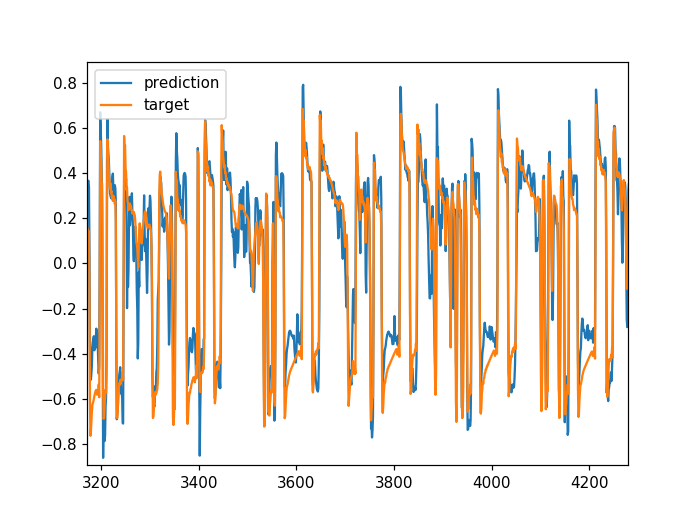

In [2]:
from show import *
%matplotlib notebook
showPickle(nameFigEstimation)